In [25]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

from functions import train_test, RMSE_list

In [2]:
def tf_idf(ratings, movies, genre_list):
    total_documents = len(movies)
    
    occurence_count = {}
    for genre in genre_list:
        occurence_count[genre] = 0

    for index, row in movies.iterrows():    
        genres = row['genres'].split('|')

        for genre in genres:
            occurence_count[genre] += 1

    idf = np.log2(total_documents/pd.Series(occurence_count))
    
    tf_idf_data = {}
    for index, row in movies.iterrows():
        tf_idf_vector = []
        
        total_terms = row['genres'].count('|') + 1
        
        for genre in genre_list:
            if genre in row['genres']:
                TF = 1/total_terms
            else:
                TF = 0
            
            tf_idf_vector.append(TF)
        
        tf_idf_data[row['movieId']] = tf_idf_vector
        
    tf_idf_df = pd.DataFrame(tf_idf_data, index=genre_list)
    
    tf_idf_df = tf_idf_df.T*idf
    
    return tf_idf_df

In [3]:
def tf_idf_predict(tf_idf_df, ratings, movies, values, k=5):
    movie_index = tf_idf_df.index
    sim = cosine_similarity(tf_idf_df)
    np.fill_diagonal(sim, -1)
    
    sim = pd.DataFrame(sim, index=movie_index, columns=movie_index)
    
    known_items = []
    top_sim = {}
    
    for u,i in values:
        if i not in known_items:
            known_items.append(i)
            top_sim[i] = list(sim.loc[int(i),:].sort_values(ascending=False)[:k].index.astype(str))
    
    
    predictions = []
    
    for u,i in values:
        row = ratings.loc[u,:]
        #known_index = row[row > 0].index.astype('int')
        
        sim_values = row.loc[top_sim[i]]
        sim_index = sim_values[sim_values > 0].index
    
        rating_predict = 0
        total_sim = 0
        
        if len(sim_index) != 0:
            for ind in sim_index:
                rating_predict += sim.loc[int(i), int(ind)]*ratings.loc[u, ind]
                total_sim += sim.loc[int(i), int(ind)]
            
            if total_sim != 0:
                rating_predict /= total_sim
            else:
                rating_predict = row[row>0].mean()
            
        else:
            rating_predict = row[row>0].mean()
            
        predictions.append(rating_predict)
    
    return predictions

In [4]:
movies = pd.read_csv('ml-latest-small/movies.csv')
ratings_df = pd.read_csv('data/user_rating_pt.csv')

columns = ratings_df.columns
movies=movies[movies['movieId'].isin(columns)]

In [5]:
genre_list = []

for index, row in movies.iterrows():
    genres = row['genres'].split('|')
    
    for g in genres:
        if g not in genre_list:
            genre_list.append(g)

In [6]:
known = []

columns = list(ratings_df.columns)
index = list(ratings_df.index)

for u in index:
    for i in columns:
        if ratings_df.loc[u,i] > 0:
            known.append((u, i))

In [7]:
training, testing = train_test(known)

In [8]:
ratings_training = ratings_df.copy()

for u,i in testing:
    ratings_training.loc[u,i] = 0

In [9]:
test_ratings = []
for u,i in testing:
    test_ratings.append(ratings_df.loc[u,i])

In [10]:
tf_idf_df = tf_idf(ratings_training, movies, genre_list)

In [14]:
rating_pred=tf_idf_predict(tf_idf_df, ratings_training, movies, testing, k=750)

In [15]:
RMSE_list(rating_pred, test_ratings)

0.9315313764240876

In [16]:
RSME_values = {}
k_values = [25, 50, 100, 250]

for k_val in k_values:
    rating_pred = tf_idf_predict(tf_idf_df, ratings_training, movies, testing, k=k_val)
    
    RSME_values[k_val] = RMSE_list(rating_pred, test_ratings)
    

In [21]:
RSME_values

{25: 1.0255994943801325,
 50: 1.0117856756051884,
 100: 0.9918504581997731,
 250: 0.9601775563905309,
 350: 0.9472762683587674,
 500: 0.937386051902938,
 750: 0.9315313764240876,
 1000: 0.9257222203915612,
 1500: 0.9172465647427535}

In [18]:
k_values2 = [350, 500, 750]

for k_val in k_values2:
    rating_pred = tf_idf_predict(tf_idf_df, ratings_training, movies, testing, k=k_val)
    
    RSME_values[k_val] = RMSE_list(rating_pred, test_ratings)
    print(k_val)

350
500
750


In [20]:
k_values3 = [1000, 1500]

for k_val in k_values3:
    rating_pred = tf_idf_predict(tf_idf_df, ratings_training, movies, testing, k=k_val)
    
    RSME_values[k_val] = RMSE_list(rating_pred, test_ratings)
    print(k_val)

1000
1500


In [24]:
RSME_df = pd.DataFrame(RSME_values, index=[0]).T
RSME_df

,0
25,1.025599
50,1.011786
100,0.991850
250,0.960178
350,0.947276
500,0.937386
750,0.931531
1000,0.925722
1500,0.917247


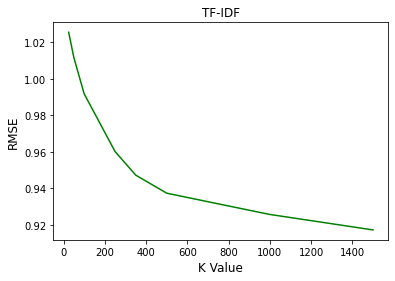

In [32]:
plt.plot(RSME_df.index, RSME_df[0], color='green')

plt.title("TF-IDF", size=12)
plt.xlabel("K Value", size=12)
plt.ylabel("RMSE", size=12)

plt.show()